In [363]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


# Model Creation Using Historical Sales Data from 2013 to 2023

## Loading and reviewing the data

In [364]:
# Load the data
data = pd.read_csv('Resources/clean_property_data.csv')

# Print the columns to check for the correct column name
print(data.columns)

Index(['district', 'nbhd', 'style', 'extwall', 'stories', 'year_built',
       'rooms', 'finishedsqft', 'units', 'bdrms', 'fbath', 'hbath', 'lotsize',
       'sale_date', 'sale_price', 'sale_year', 'sale_month'],
      dtype='object')


In [365]:
# Clean column names by stripping any extra spaces
data.columns = data.columns.str.strip()
# Check the cleaned column names
print(data.columns)

Index(['district', 'nbhd', 'style', 'extwall', 'stories', 'year_built',
       'rooms', 'finishedsqft', 'units', 'bdrms', 'fbath', 'hbath', 'lotsize',
       'sale_date', 'sale_price', 'sale_year', 'sale_month'],
      dtype='object')


In [366]:
# Check data types for each column to see if any conversions are needed
data.info(type)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37764 entries, 0 to 37763
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   district      37764 non-null  int64  
 1   nbhd          37764 non-null  int64  
 2   style         37764 non-null  object 
 3   extwall       37764 non-null  object 
 4   stories       37764 non-null  float64
 5   year_built    37764 non-null  int64  
 6   rooms         37764 non-null  int64  
 7   finishedsqft  37764 non-null  int64  
 8   units         37764 non-null  int64  
 9   bdrms         37764 non-null  int64  
 10  fbath         37764 non-null  int64  
 11  hbath         37764 non-null  int64  
 12  lotsize       37764 non-null  int64  
 13  sale_date     37764 non-null  object 
 14  sale_price    37764 non-null  int64  
 15  sale_year     37764 non-null  int64  
 16  sale_month    37764 non-null  int64  
dtypes: float64(1), int64(13), object(3)
memory usage: 4.9+ MB


In [367]:
# Combining full bath and half bath columns into 1 to align with the property listings data
data['baths_total'] = data['fbath'] + data['hbath']
# Dropping 'fbath', 'hbath', and 'year_built' columns as they are not available in the property listings data
data = data.drop(columns=['fbath','hbath','year_built'])
# Check for any null values
data.isnull().sum()

district        0
nbhd            0
style           0
extwall         0
stories         0
rooms           0
finishedsqft    0
units           0
bdrms           0
lotsize         0
sale_date       0
sale_price      0
sale_year       0
sale_month      0
baths_total     0
dtype: int64

In [368]:
# Converting the sale date to datetime , becasue when imported here it couldn't read it as datetime
data['sale_date'] = pd.to_datetime(data['sale_date'], errors='coerce')
data.info(type)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37764 entries, 0 to 37763
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   district      37764 non-null  int64         
 1   nbhd          37764 non-null  int64         
 2   style         37764 non-null  object        
 3   extwall       37764 non-null  object        
 4   stories       37764 non-null  float64       
 5   rooms         37764 non-null  int64         
 6   finishedsqft  37764 non-null  int64         
 7   units         37764 non-null  int64         
 8   bdrms         37764 non-null  int64         
 9   lotsize       37764 non-null  int64         
 10  sale_date     37764 non-null  datetime64[ns]
 11  sale_price    37764 non-null  int64         
 12  sale_year     37764 non-null  int64         
 13  sale_month    37764 non-null  int64         
 14  baths_total   37764 non-null  int64         
dtypes: datetime64[ns](1), float64(1), in

In [369]:
# Dropping saledate because it's not needed for the model. We're going to use sale-year and sale-month
data = data.drop(columns=['sale_date'])
data = data.rename(columns={'sale_year': 'year', 'sale_month':'month'})
data = data[['district','nbhd','style','extwall','stories','rooms','finishedsqft','lotsize','units','bdrms','baths_total','year','month','sale_price']]
data

,district,nbhd,style,extwall,stories,rooms,finishedsqft,lotsize,units,bdrms,baths_total,year,month,sale_price
0,9,40,cape cod,aluminum/vinyl,1.0,7,1182,33541,1,4,2,2023,12,160000
1,9,40,ranch,fiber cement/hardiplank,1.0,9,1880,10607,1,3,2,2023,8,387500
2,9,40,ranch,aluminum/vinyl,1.0,6,1489,8640,1,3,3,2023,8,335000
3,9,40,ranch,aluminum/vinyl,1.0,5,1209,7200,1,3,2,2023,6,250000
4,9,40,colonial,aluminum/vinyl,2.0,6,1663,7200,1,3,3,2023,1,270000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37759,14,4180,milwaukee bungalow,aluminum / vinyl,1.0,0,988,3660,1,3,1,2013,12,61500
37760,14,4620,ranch,aluminum / vinyl,1.0,0,1119,5120,1,3,1,2013,12,65000
37761,14,4700,ranch,aluminum / vinyl,1.0,0,725,5546,1,2,1,2013,12,97500
37762,14,4600,residence o/s,aluminum / vinyl,1.0,0,937,4560,1,2,1,2013,12,149000


## Creating dummy data for the categorical column information

In [370]:
# Converting all non-numerical values to numerical category 
data_dummies = pd.get_dummies(data)
data_dummies

,district,nbhd,stories,rooms,finishedsqft,lotsize,units,bdrms,baths_total,year,...,extwall_frame,extwall_masonary frame,extwall_masonry / frame,extwall_masonry/frame,extwall_metal siding,extwall_precast masonary,extwall_prem wood,extwall_stone,extwall_stucco,extwall_wood
0,9,40,1.0,7,1182,33541,1,4,2,2023,...,False,False,False,False,False,False,False,False,False,False
1,9,40,1.0,9,1880,10607,1,3,2,2023,...,False,False,False,False,False,False,False,False,False,False
2,9,40,1.0,6,1489,8640,1,3,3,2023,...,False,False,False,False,False,False,False,False,False,False
3,9,40,1.0,5,1209,7200,1,3,2,2023,...,False,False,False,False,False,False,False,False,False,False
4,9,40,2.0,6,1663,7200,1,3,3,2023,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37759,14,4180,1.0,0,988,3660,1,3,1,2013,...,False,False,False,False,False,False,False,False,False,False
37760,14,4620,1.0,0,1119,5120,1,3,1,2013,...,False,False,False,False,False,False,False,False,False,False
37761,14,4700,1.0,0,725,5546,1,2,1,2013,...,False,False,False,False,False,False,False,False,False,False
37762,14,4600,1.0,0,937,4560,1,2,1,2013,...,False,False,False,False,False,False,False,False,False,False


In [371]:
# Sort the columns by alphabetical order so it's easier to organize when feeding the inputs for the model
data_dummies = data_dummies.reindex(sorted(data_dummies.columns), axis=1)

In [372]:
# Exporting the data to use for finding the missing columns from the listings data later
data_dummies.to_csv("Resources\historicalsales-dummy-data.csv")

## Defining Model Features and Creating the Training and Testing Datasets

In [373]:
# Creating the independent variables set by dropping the column to be used for the target feature
X = data_dummies.drop(columns=['sale_price'])
X

,baths_total,bdrms,district,extwall_alum/vynyl siding,extwall_aluminum / vinyl,extwall_aluminum/vinyl,extwall_asphalt/other,extwall_block,extwall_brick,extwall_fiber cement/hardiplank,...,style_res o/s 2sty +,style_res o/s a & 1/2,style_residence o/s,style_residence o/s 2sty+,style_split level,style_townhouse,style_triplex,style_tudor,units,year
0,2,4,9,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,1,2023
1,2,3,9,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,1,2023
2,3,3,9,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,1,2023
3,2,3,9,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,1,2023
4,3,3,9,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,1,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37759,1,3,14,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1,2013
37760,1,3,14,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1,2013
37761,1,2,14,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1,2013
37762,1,2,14,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,1,2013


In [374]:
# Creating the dependent variable set 
y = data_dummies['sale_price']
y

0        160000
1        387500
2        335000
3        250000
4        270000
          ...  
37759     61500
37760     65000
37761     97500
37762    149000
37763    102900
Name: sale_price, Length: 37764, dtype: int64

In [375]:
# Spliting data into training and testing 90/10 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Model Creation

### Linear Regression Model


In [376]:
# Setting the model to linear regression 
model = LinearRegression()
# Fitting the model 
model.fit(X_train, y_train)

LinearRegression()

In [377]:
# Evaluating the coefficients for each column to see if they have any relationship with each other
coef = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coef

,Coefficient
baths_total,26058.035128
bdrms,-3943.759205
district,-2254.037903
extwall_alum/vynyl siding,52410.447666
extwall_aluminum / vinyl,-10306.114444
extwall_aluminum/vinyl,-15717.612129
extwall_asphalt/other,-29819.538203
extwall_block,-15270.627446
extwall_brick,-11056.128046
extwall_fiber cement/hardiplank,67037.428883


In [378]:
# Ensuring X_train and y_train are in scope and convert to numeric types
X_train_numeric = sm.add_constant(X_train).astype(float)
y_train_numeric = y_train.astype(float)

# Fitting the model using statsmodels OLS
model_sm = sm.OLS(y_train_numeric, X_train_numeric).fit()

# Getting the p-values
p_values = model_sm.pvalues

# Creating a DataFrame for the coefficients and p-values
coef_pvalues = pd.DataFrame({'Coefficient': model_sm.params[1:], 'p-value': p_values[1:]})
coef_pvalues.index = X.columns
print(coef_pvalues)

# Displaying the full summary of the model
print(model_sm.summary())

                                   Coefficient        p-value
baths_total                       2.605804e+04   0.000000e+00
bdrms                            -3.943759e+03   1.311949e-21
district                         -2.254038e+03   5.187774e-77
extwall_alum/vynyl siding        -9.531500e+05  3.322156e-176
extwall_aluminum / vinyl         -1.015867e+06   0.000000e+00
extwall_aluminum/vinyl           -1.021278e+06   0.000000e+00
extwall_asphalt/other            -1.035380e+06   0.000000e+00
extwall_block                    -1.020831e+06   0.000000e+00
extwall_brick                    -1.016617e+06   0.000000e+00
extwall_fiber cement/hardiplank  -9.385230e+05   0.000000e+00
extwall_fiber-cement             -9.918612e+05   0.000000e+00
extwall_frame                    -1.016461e+06   0.000000e+00
extwall_masonary frame           -1.047833e+06   2.950365e-58
extwall_masonry / frame          -1.021043e+06   0.000000e+00
extwall_masonry/frame            -1.016059e+06   0.000000e+00
extwall_

In [379]:
# Prediction with test data 
y_pred = model.predict(X_test)
# Getting mean square 
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 20103128979.547203


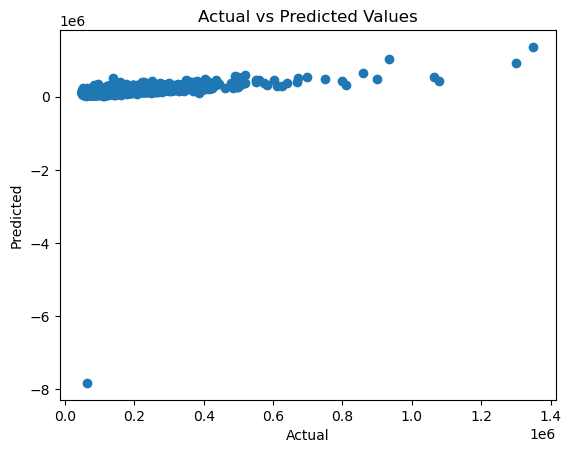

In [380]:
# Plotting graph between real and predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
# plt.ylim(0, 1600000)
plt.show()

In [381]:
# determining accuracy score 
model.score(X_test, y_test)

-1.4185689522682736

### Random Forest Regression Model

In [382]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

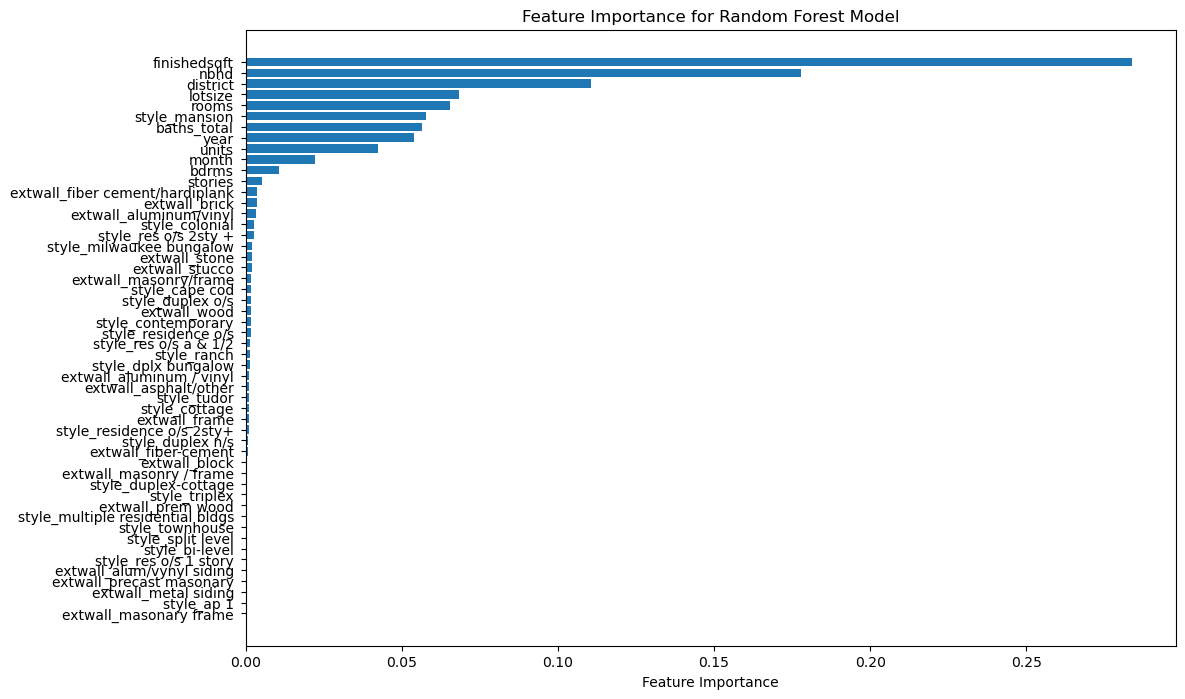

In [383]:
# Feature Importance for Random Forest
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 8))  # Increased figure size
plt.barh(feature_importances.index, feature_importances['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Random Forest Model')

# Adjust y-axis label spacing
plt.gca().invert_yaxis()  # Highest importance at the top
plt.gca().yaxis.set_tick_params(pad=5)  # Increase space between labels

plt.show()

In [384]:
y_pred = model.predict(X_test)
# getting mean square 
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1585831412.7670312


Text(0.5, 1.0, 'Actual vs Predicted Values')

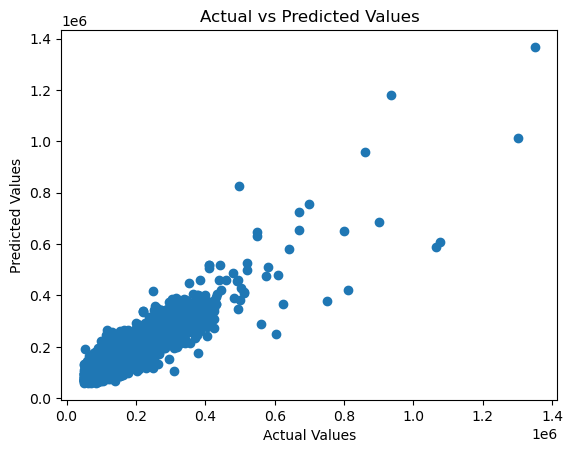

In [385]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

In [386]:
model.score(X_test, y_test)

0.8092116594211662

The Random Forest Regression Model provides the best performance with an accuracy of 79.9%. Therefore, we will proceed with this model for predicting the house prices in the next section.

# House Price Prediction on 2023 Listings Data

In [387]:
# Importing the proeprty listings dataset and viewing the first 5 rows
listings_data_df = pd.read_csv("Resources/original_extracted_df_MilwaukeeOnly_June11.csv")
listings_data_df.head()

,district,nbhd,style,extwall,stories,rooms,finishedsqft,lotsize,units,bdrms,...,address,zipcode,latitude,longitude,ppsq,convertedlot,lotunit,marketestimate,rentestimate,price
0,7,1440,milwaukee bungalow,aluminum/vinyl,1.0,7,1400,3484.8,1,3,...,South 8th STREET,53215,42.996044,-87.921000,110.714286,0.08,sqft,156700.0,1300.0,155000
1,12,4120,duplex-cottage,wood,2.0,10,1600,3484.8,2,3,...,East Homer STREET,53207,42.999760,-87.899940,218.687500,0.08,sqft,370200.0,1999.0,349900
2,10,2710,cottage,aluminum/vinyl,1.0,4,667,4356.0,1,2,...,North 35th STREET,53216,43.095448,-87.957344,206.146927,0.10,sqft,139700.0,996.0,137500
3,15,2400,colonial,aluminum/vinyl,2.0,6,1184,4356.0,1,3,...,North 25th STREET,53205,43.056957,-87.944756,114.020270,0.10,sqft,132800.0,1500.0,135000
4,13,4520,colonial,aluminum/vinyl,2.0,6,1300,4356.0,1,3,...,South Whitnall AVENUE,53207,42.982292,-87.905945,260.769231,0.10,sqft,360000.0,1875.0,339000


In [388]:
# Reviewing the datatypes to see if any conversions are needed
listings_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   district        25 non-null     int64  
 1   nbhd            25 non-null     int64  
 2   style           25 non-null     object 
 3   extwall         25 non-null     object 
 4   stories         25 non-null     float64
 5   rooms           25 non-null     int64  
 6   finishedsqft    25 non-null     int64  
 7   lotsize         25 non-null     float64
 8   units           25 non-null     int64  
 9   bdrms           25 non-null     int64  
 10  baths_total     25 non-null     int64  
 11  state           25 non-null     object 
 12  city            25 non-null     object 
 13  address         25 non-null     object 
 14  zipcode         25 non-null     int64  
 15  latitude        25 non-null     float64
 16  longitude       25 non-null     float64
 17  ppsq            25 non-null     float

In [389]:
# Dropping columns that are not needed for this project and confirming they have been dropped
listings_data_df = listings_data_df.drop(columns=['ppsq', 'convertedlot','lotunit','rentestimate'], axis=1)
listings_data_df.columns

Index(['district', 'nbhd', 'style', 'extwall', 'stories', 'rooms',
       'finishedsqft', 'lotsize', 'units', 'bdrms', 'baths_total', 'state',
       'city', 'address', 'zipcode', 'latitude', 'longitude', 'marketestimate',
       'price'],
      dtype='object')

In [390]:
# Creating copy of dataframe for showing results in interface
display_info_df = listings_data_df.copy()

In [391]:
# Preparing listings_data_df for input features into the model
# Setting the prediction date to June of 2024
predictions_df = listings_data_df.copy()
predictions_df = predictions_df.drop(columns=['state','city', 'address', 'zipcode', 'latitude', 'longitude', 'marketestimate','price'], axis=1)
predictions_df['year'] = 2024
predictions_df['month'] = 6
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   district      25 non-null     int64  
 1   nbhd          25 non-null     int64  
 2   style         25 non-null     object 
 3   extwall       25 non-null     object 
 4   stories       25 non-null     float64
 5   rooms         25 non-null     int64  
 6   finishedsqft  25 non-null     int64  
 7   lotsize       25 non-null     float64
 8   units         25 non-null     int64  
 9   bdrms         25 non-null     int64  
 10  baths_total   25 non-null     int64  
 11  year          25 non-null     int64  
 12  month         25 non-null     int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 2.7+ KB


In [392]:
# Converting the categorial data in 'style' and 'extwall' to dummy data columns
predictions_dummies = pd.get_dummies(predictions_df)
predictions_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   district                  25 non-null     int64  
 1   nbhd                      25 non-null     int64  
 2   stories                   25 non-null     float64
 3   rooms                     25 non-null     int64  
 4   finishedsqft              25 non-null     int64  
 5   lotsize                   25 non-null     float64
 6   units                     25 non-null     int64  
 7   bdrms                     25 non-null     int64  
 8   baths_total               25 non-null     int64  
 9   year                      25 non-null     int64  
 10  month                     25 non-null     int64  
 11  style_bi-level            25 non-null     bool   
 12  style_cape cod            25 non-null     bool   
 13  style_colonial            25 non-null     bool   
 14  style_cottag

In [393]:
# Exporting to compare against the historical sales dummy data to find the missing columns in the listings dummy data
predictions_dummies.to_csv("Resources\listings-dummy-data.csv")

In [394]:
# Fill in the missing columns from the historical sales dummy data and confirm that the current number of columns is present (52)
missing_columns = ['style_ap 1','style_contemporary','style_duplex o/s','style_mansion','style_multiple residential bldgs','style_residence o/s','style_res o/s 1 story','style_res o/s a & 1/2','style_residence o/s 2sty+','style_split level','style_townhouse','style_triplex','style_tudor','extwall_alum/vynyl siding','extwall_asphalt/other','extwall_fiber cement/hardiplank','extwall_fiber-cement','extwall_frame','extwall_masonary frame','extwall_masonry / frame','extwall_masonry/frame','extwall_metal siding','extwall_precast masonary','extwall_prem wood']
for col in missing_columns:
    predictions_dummies[col] = False
predictions_dummies.head()

,district,nbhd,stories,rooms,finishedsqft,lotsize,units,bdrms,baths_total,year,...,extwall_asphalt/other,extwall_fiber cement/hardiplank,extwall_fiber-cement,extwall_frame,extwall_masonary frame,extwall_masonry / frame,extwall_masonry/frame,extwall_metal siding,extwall_precast masonary,extwall_prem wood
0,7,1440,1.0,7,1400,3484.8,1,3,1,2024,...,False,False,False,False,False,False,False,False,False,False
1,12,4120,2.0,10,1600,3484.8,2,3,2,2024,...,False,False,False,False,False,False,False,False,False,False
2,10,2710,1.0,4,667,4356.0,1,2,1,2024,...,False,False,False,False,False,False,False,False,False,False
3,15,2400,2.0,6,1184,4356.0,1,3,2,2024,...,False,False,False,False,False,False,False,False,False,False
4,13,4520,2.0,6,1300,4356.0,1,3,2,2024,...,False,False,False,False,False,False,False,False,False,False


In [395]:
# Sort the columns in alphabetical order to align with the input features order of the random forest regression model
predictions_dummies = predictions_dummies.reindex(sorted(predictions_dummies.columns), axis=1)
predictions_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 52 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   baths_total                       25 non-null     int64  
 1   bdrms                             25 non-null     int64  
 2   district                          25 non-null     int64  
 3   extwall_alum/vynyl siding         25 non-null     bool   
 4   extwall_aluminum / vinyl          25 non-null     bool   
 5   extwall_aluminum/vinyl            25 non-null     bool   
 6   extwall_asphalt/other             25 non-null     bool   
 7   extwall_block                     25 non-null     bool   
 8   extwall_brick                     25 non-null     bool   
 9   extwall_fiber cement/hardiplank   25 non-null     bool   
 10  extwall_fiber-cement              25 non-null     bool   
 11  extwall_frame                     25 non-null     bool   
 12  extwall_ma

In [396]:
# Create a copy of the predcition dummy data and run the model to get the 2024 house price predictions for the properties in the listings data
# Store the predictions in a new column in the display_info_df dataframe
X_pred1 = predictions_dummies.copy()
y_pred1 = model.predict(X_pred1)
display_info_df['2024 predictions'] = y_pred1
display_info_df['Price difference'] = display_info_df['2024 predictions'] - display_info_df['price'] 

# X_pred2 = predictions_dummies.copy()
# X_pred2['year']=2026
# y_pred2 = model.predict(X_pred2)
# display_info_df['2026 predictions'] = y_pred2

# X_pred3 = predictions_dummies.copy()
# X_pred3['year']=2028
# y_pred3 = model.predict(X_pred3)
# display_info_df['2028 predictions'] = y_pred3

display_info_df

,district,nbhd,style,extwall,stories,rooms,finishedsqft,lotsize,units,bdrms,...,state,city,address,zipcode,latitude,longitude,marketestimate,price,2024 predictions,Price difference
0,7,1440,milwaukee bungalow,aluminum/vinyl,1.0,7,1400,3484.8,1,3,...,WI,Milwaukee,South 8th STREET,53215,42.996044,-87.921000,156700.0,155000,109479.08,-45520.92
1,12,4120,duplex-cottage,wood,2.0,10,1600,3484.8,2,3,...,WI,Milwaukee,East Homer STREET,53207,42.999760,-87.899940,370200.0,349900,118689.65,-231210.35
2,10,2710,cottage,aluminum/vinyl,1.0,4,667,4356.0,1,2,...,WI,Milwaukee,North 35th STREET,53216,43.095448,-87.957344,139700.0,137500,133050.00,-4450.00
3,15,2400,colonial,aluminum/vinyl,2.0,6,1184,4356.0,1,3,...,WI,Milwaukee,North 25th STREET,53205,43.056957,-87.944756,132800.0,135000,135061.00,61.00
4,13,4520,colonial,aluminum/vinyl,2.0,6,1300,4356.0,1,3,...,WI,Milwaukee,South Whitnall AVENUE,53207,42.982292,-87.905945,360000.0,339000,267721.00,-71279.00
5,11,4260,cape cod,aluminum/vinyl,1.0,0,953,4791.6,1,2,...,WI,Milwaukee,North 78th STREET,53222,43.074600,-88.009514,192900.0,179000,163804.00,-15196.00
6,10,2540,milwaukee bungalow,aluminum/vinyl,1.0,0,1234,4791.6,1,2,...,WI,Milwaukee,S Alabama Ave,53207,42.982690,-87.887985,263300.0,249800,178382.00,-71418.00
7,7,1740,dplx bungalow,block,1.5,7,1532,4791.6,2,3,...,WI,Milwaukee,North 45th STREET,53216,43.081413,-87.970080,183800.0,179000,124644.00,-54356.00
8,3,3160,dplx bungalow,stucco,2.0,12,2739,4791.6,2,5,...,WI,Milwaukee,North 50th STREET,53216,43.076060,-87.976380,257300.0,260000,407718.00,147718.00
9,6,2910,res o/s 2sty +,wood,2.0,0,1884,5000.0,2,2,...,OR,Milwaukie,SE Sellwood St,97222,45.440216,-122.628470,NaN,275000,173326.20,-101673.80


In [397]:
# Export the final display table for use in the final interactive dashboard
display_info_df.to_csv("Resources\/final-listings-dataset-with-predictions.csv")